<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/daging_sapi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [ ]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [ ]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fdae41072b0>)

In [ ]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [ ]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [ ]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.daging_sapi_kualitas_2.values
date = dataset.index

## Train test val split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


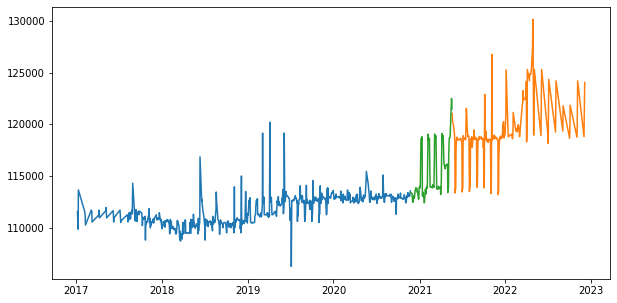

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [ ]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [ ]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_sapi2_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 17s 47ms/step - loss: 0.2442 - mae: 0.4923 - mape: 102.6919 - val_loss: 0.1850 - val_mae: 0.3579 - val_mape: 78.3932
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.1518 - mae: 0.3876 - mape: 80.7691 - val_loss: 0.1407 - val_mae: 0.2940 - val_mape: 58.2231
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0995 - mae: 0.3135 - mape: 65.2788 - val_loss: 0.1121 - val_mae: 0.2600 - val_mape: 55.0068
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0670 - mae: 0.2567 - mape: 53.3883 - val_loss: 0.0924 - val_mae: 0.2388 - val_mape: 57.5245
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0458 - mae: 0.2116 - mape: 43.9374 - val_loss: 0.0791 - val_mae: 0.2209 - val_mape: 59.6489
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0313 - mae: 0.1744 - mape: 36.1491 - val_loss: 0.0704 - val_mae: 0.2059 - val_mape: 61.4

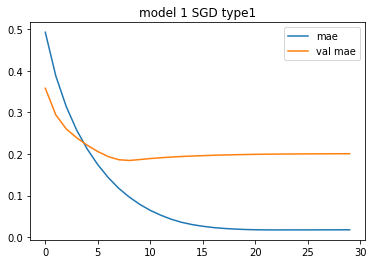

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
2313.3416 1.912223 3213.488291561057


,date,actual,prediction
0,2021-05-20,121050,116866.437500
1,2021-05-21,120300,116867.476562
2,2021-05-24,120050,116917.171875
3,2021-05-25,119900,116976.445312
4,2021-05-27,119500,117037.734375
...,...,...,...
229,2022-11-02,119350,117511.078125
230,2022-11-03,121850,117512.726562
231,2022-11-04,124200,117523.007812
232,2022-12-01,118800,117523.500000


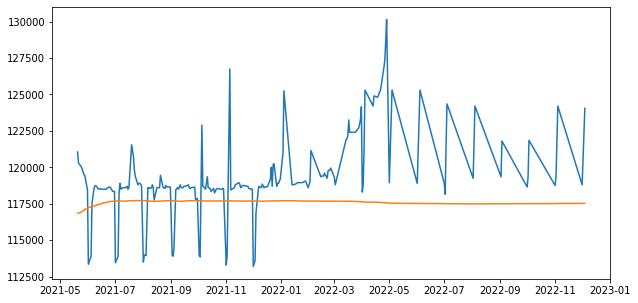

In [ ]:
prediction = forecast_predict(model, test_sapi2_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_sapi2 = pd.DataFrame()
data_new_sapi2['date'] = y_test
data_new_sapi2['actual'] = x_test
data_new_sapi2['prediction'] = data_result
data_new_sapi2.to_csv('sapi2_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_sapi2.date, data_new_sapi2.actual)
plt.plot(data_new_sapi2.date, data_new_sapi2.prediction)
data_new_sapi2

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0077 - mae: 0.0641 - mape: 536857.8125 - val_loss: 0.0565 - val_mae: 0.1964 - val_mape: 83.4016
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0071 - mae: 0.0609 - mape: 526106.6250 - val_loss: 0.0565 - val_mae: 0.1964 - val_mape: 83.4214
Epoch 3/30
718/718 [==============================] - 7s 10ms/step - loss: 0.0070 - mae: 0.0607 - mape: 533242.1875 - val_loss: 0.0565 - val_mae: 0.1965 - val_mape: 83.4220
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0072 - mae: 0.0615 - mape: 571990.5000 - val_loss: 0.0564 - val_mae: 0.1956 - val_mape: 82.2646
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0069 - mae: 0.0593 - mape: 556829.8125 - val_loss: 0.0563 - val_mae: 0.1953 - val_mape: 81.9345
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0068 - mae: 0.0589 - mape: 536373.9375 - val_loss: 0.0563 - val

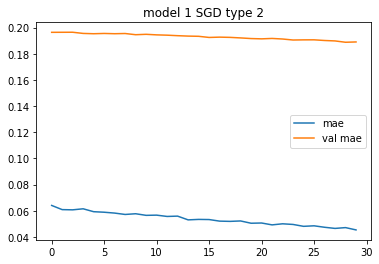

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2448.4656 2.0250564 3293.8800828202598


,date,actual,prediction
0,2021-05-20,121050,116866.437500
1,2021-05-21,120300,116867.476562
2,2021-05-24,120050,116917.171875
3,2021-05-25,119900,116976.445312
4,2021-05-27,119500,117037.734375
...,...,...,...
229,2022-11-02,119350,117511.078125
230,2022-11-03,121850,117512.726562
231,2022-11-04,124200,117523.007812
232,2022-12-01,118800,117523.500000


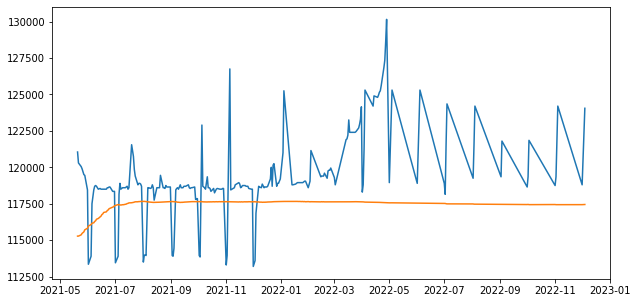

In [ ]:
win_size1 = 60
test_sapi2_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_sapi2_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_sapi2_1 = pd.DataFrame()
data_new_sapi2_1['actual'] = x_test
data_new_sapi2_1['prediction'] = data_result_1
data_new_sapi2_1.to_csv('sapi2_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi2_1.actual)
plt.plot(y_test, data_new_sapi2_1.prediction)
data_new_sapi2

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0036 - mae: 0.0305 - mape: 1122897.2500 - val_loss: 0.0565 - val_mae: 0.1888 - val_mape: 72.9389
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0036 - mae: 0.0305 - mape: 1114331.7500 - val_loss: 0.0566 - val_mae: 0.1887 - val_mape: 72.7819
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0306 - mape: 1111064.3750 - val_loss: 0.0567 - val_mae: 0.1884 - val_mape: 72.3635
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0307 - mape: 1113071.0000 - val_loss: 0.0567 - val_mae: 0.1884 - val_mape: 72.3783
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0036 - mae: 0.0311 - mape: 1107895.2500 - val_loss: 0.0567 - val_mae: 0.1883 - val_mape: 72.2044
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0306 - mape: 1115713.1250 - val_loss: 0.0566 - val_

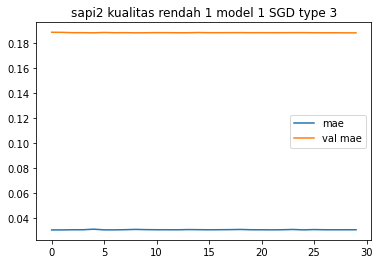

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('sapi2 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2469.6096 2.0427656 3305.5004159733517


,actual,prediction
0,121050,115169.960938
1,120300,115171.203125
2,120050,115253.820312
3,119900,115351.101562
4,119500,115455.023438
...,...,...
229,119350,117431.953125
230,121850,117442.796875
231,124200,117431.304688
232,118800,117441.937500


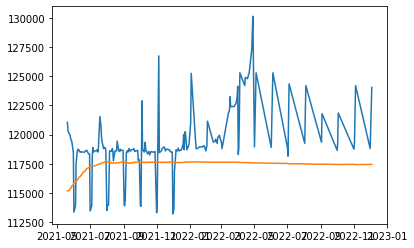

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_sapi2_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_sapi2_2 = pd.DataFrame()
# data_new_sapi21['date'] = date_test
data_new_sapi2_2['actual'] = x_test
data_new_sapi2_2['prediction'] = data_result_2
data_new_sapi2_2.to_csv('sapi2_model1_sgd_type3')

plt.plot(y_test, data_new_sapi2_2.actual)
plt.plot(y_test, data_new_sapi2_2.prediction)
data_new_sapi2_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 39ms/step - loss: 0.2289 - mae: 0.4771 - mape: 99.4784 - val_loss: 0.2039 - val_mae: 0.3837 - val_mape: 88.0659
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1709 - mae: 0.4120 - mape: 85.8717 - val_loss: 0.1651 - val_mae: 0.3294 - val_mape: 68.1880
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.1085 - mae: 0.3266 - mape: 68.0333 - val_loss: 0.1133 - val_mae: 0.2614 - val_mape: 54.9486
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0309 - mae: 0.1605 - mape: 33.2500 - val_loss: 0.0608 - val_mae: 0.1863 - val_mape: 64.6459
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0012 - mae: 0.0240 - mape: 4.9300 - val_loss: 0.0577 - val_mae: 0.1863 - val_mape: 69.3038
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 9.1403e-04 - mae: 0.0183 - mape: 3.7186 - val_loss: 0.0576 - val_mae: 0.1864 - val_mape: 69.6

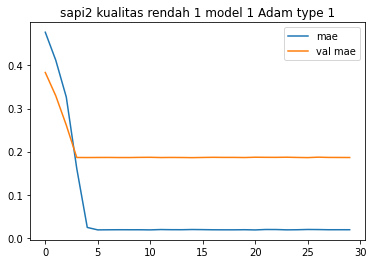

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('sapi2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
2010.8087 1.6685503 2710.0746299687025


,actual,prediction
0,121050,114826.617188
1,120300,114818.570312
2,120050,114911.828125
3,119900,115000.343750
4,119500,115114.078125
...,...,...
229,119350,120029.648438
230,121850,120272.023438
231,124200,119908.507812
232,118800,120151.312500


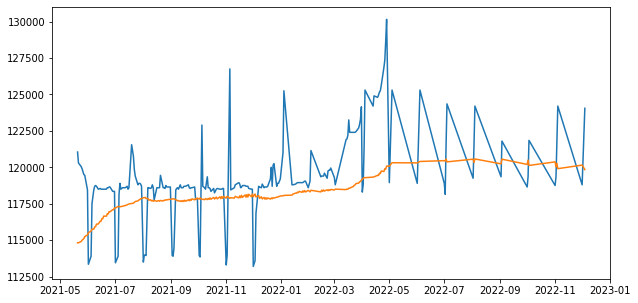

In [ ]:
prediction_a = forecast_predict(model_a, test_sapi2_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_sapi2_a = pd.DataFrame()
# data_new_sapi21['date'] = date_test
data_new_sapi2_a['actual'] = x_test
data_new_sapi2_a['prediction'] = data_result_a
data_new_sapi2_a.to_csv('sapi2_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_sapi2_a.actual)
plt.plot(y_test, data_new_sapi2_a.prediction)
data_new_sapi2_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0046 - mae: 0.0407 - mape: 630309.6250 - val_loss: 0.0580 - val_mae: 0.1866 - val_mape: 68.8930
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0045 - mae: 0.0397 - mape: 613919.4375 - val_loss: 0.0575 - val_mae: 0.1869 - val_mape: 69.6317
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0047 - mae: 0.0394 - mape: 605743.6250 - val_loss: 0.0579 - val_mae: 0.1866 - val_mape: 68.7310
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0046 - mae: 0.0392 - mape: 584801.0000 - val_loss: 0.0593 - val_mae: 0.1857 - val_mape: 66.0531
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0044 - mae: 0.0384 - mape: 631251.8750 - val_loss: 0.0581 - val_mae: 0.1867 - val_mape: 68.2686
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0044 - mae: 0.0390 - mape: 608035.1875 - val_loss: 0.0577 - val_

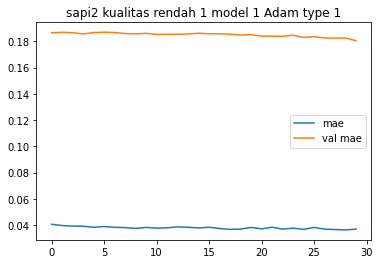

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('sapi2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
1837.6737 1.5283021 2537.8048585342412


,actual,prediction
0,121050,114036.687500
1,120300,114050.078125
2,120050,114455.148438
3,119900,114466.187500
4,119500,114893.367188
...,...,...
229,119350,120798.742188
230,121850,121040.945312
231,124200,120652.367188
232,118800,121042.460938


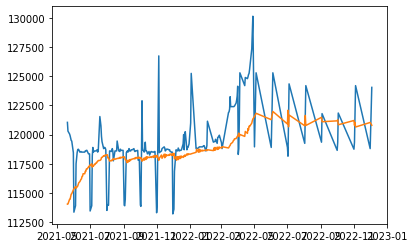

In [ ]:
prediction_a1 = forecast_predict(model_a, test_sapi2_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_sapi2_a1 = pd.DataFrame()
data_new_sapi2_a1['actual'] = x_test
data_new_sapi2_a1['prediction'] = data_result_a1
data_new_sapi2_a1.to_csv('sapi2_model1_adam_type2.csv')

plt.plot(y_test, data_new_sapi2_a1.actual)
plt.plot(y_test, data_new_sapi2_a1.prediction)
data_new_sapi2_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0036 - mae: 0.0306 - mape: 1083663.5000 - val_loss: 0.0582 - val_mae: 0.1823 - val_mape: 61.2208
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0302 - mape: 1090851.1250 - val_loss: 0.0569 - val_mae: 0.1806 - val_mape: 62.2776
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0309 - mape: 1106701.1250 - val_loss: 0.0566 - val_mae: 0.1802 - val_mape: 62.4622
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0304 - mape: 1109830.8750 - val_loss: 0.0569 - val_mae: 0.1806 - val_mape: 62.1187
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0307 - mape: 1091619.3750 - val_loss: 0.0556 - val_mae: 0.1802 - val_mape: 63.7741
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0303 - mape: 1104747.0000 - val_loss: 0.0568 - val_

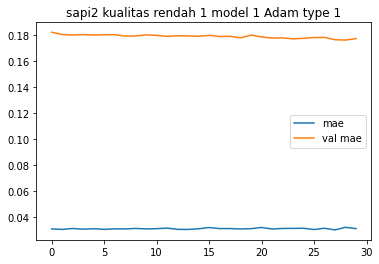

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('sapi2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
1969.6251 1.6346341 2700.260635568352


,actual,prediction
0,121050,114209.140625
1,120300,114212.171875
2,120050,114674.203125
3,119900,114628.523438
4,119500,115061.273438
...,...,...
229,119350,119907.773438
230,121850,119898.359375
231,124200,119918.085938
232,118800,120083.828125


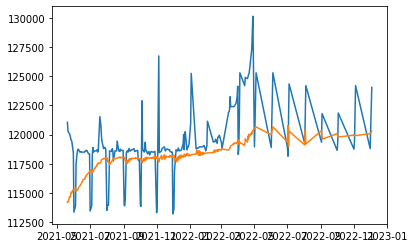

In [ ]:
prediction_a2 = forecast_predict(model_a, test_sapi2_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_sapi2_a2 = pd.DataFrame()
# data_new_sapi21['date'] = date_test
data_new_sapi2_a2['actual'] = x_test
data_new_sapi2_a2['prediction'] = data_result_a2
data_new_sapi2_a2.to_csv('sapi2_model1_adam_type3.csv')

plt.plot(y_test, data_new_sapi2_a2.actual)
plt.plot(y_test, data_new_sapi2_a2.prediction)
data_new_sapi2_a2

## model 1

### Adam

In [ ]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 4s 42ms/step - loss: 0.1408 - mae: 0.3618 - mape: 75.4029 - val_loss: 0.0754 - val_mae: 0.2173 - val_mape: 60.6109
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0033 - mae: 0.0455 - mape: 9.4692 - val_loss: 0.0593 - val_mae: 0.1841 - val_mape: 65.1513
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0010 - mae: 0.0202 - mape: 4.1112 - val_loss: 0.0605 - val_mae: 0.1866 - val_mape: 64.4168
Epoch 4/15
44/44 [==============================] - 1s 21ms/step - loss: 9.2233e-04 - mae: 0.0189 - mape: 3.8412 - val_loss: 0.0617 - val_mae: 0.1897 - val_mape: 63.9238
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 9.6220e-04 - mae: 0.0195 - mape: 3.9826 - val_loss: 0.0606 - val_mae: 0.1869 - val_mape: 64.3786
Epoch 6/15
44/44 [==============================] - 1s 21ms/step - loss: 9.4745e-04 - mae: 0.0197 - mape: 4.0066 - val_loss: 0.0598 - val_mae: 0.1851 - val_mape:

17/17 [==============================] - 0s 6ms/step - loss: 0.0275 - mae: 0.1238 - mape: 23.3523


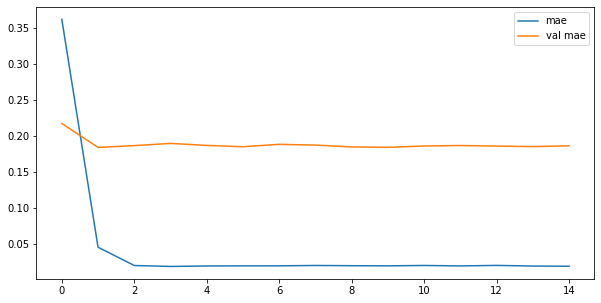

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_sapi2_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_sapi21 = pd.DataFrame()
data_new_sapi21['actual'] = x_test
data_new_sapi21['prediction'] = data_result1
data_new_sapi21.to_csv('sapi2_model2_adam_type1.csv')

data_new_sapi21

131/131 [==============================] - 2s 7ms/step
2210.157 1.8329793 2913.4096862611


,actual,prediction
0,121050,114535.351562
1,120300,114568.531250
2,120050,114562.976562
3,119900,114611.742188
4,119500,114630.539062
...,...,...
229,119350,120037.218750
230,121850,119847.351562
231,124200,120013.250000
232,118800,119826.453125


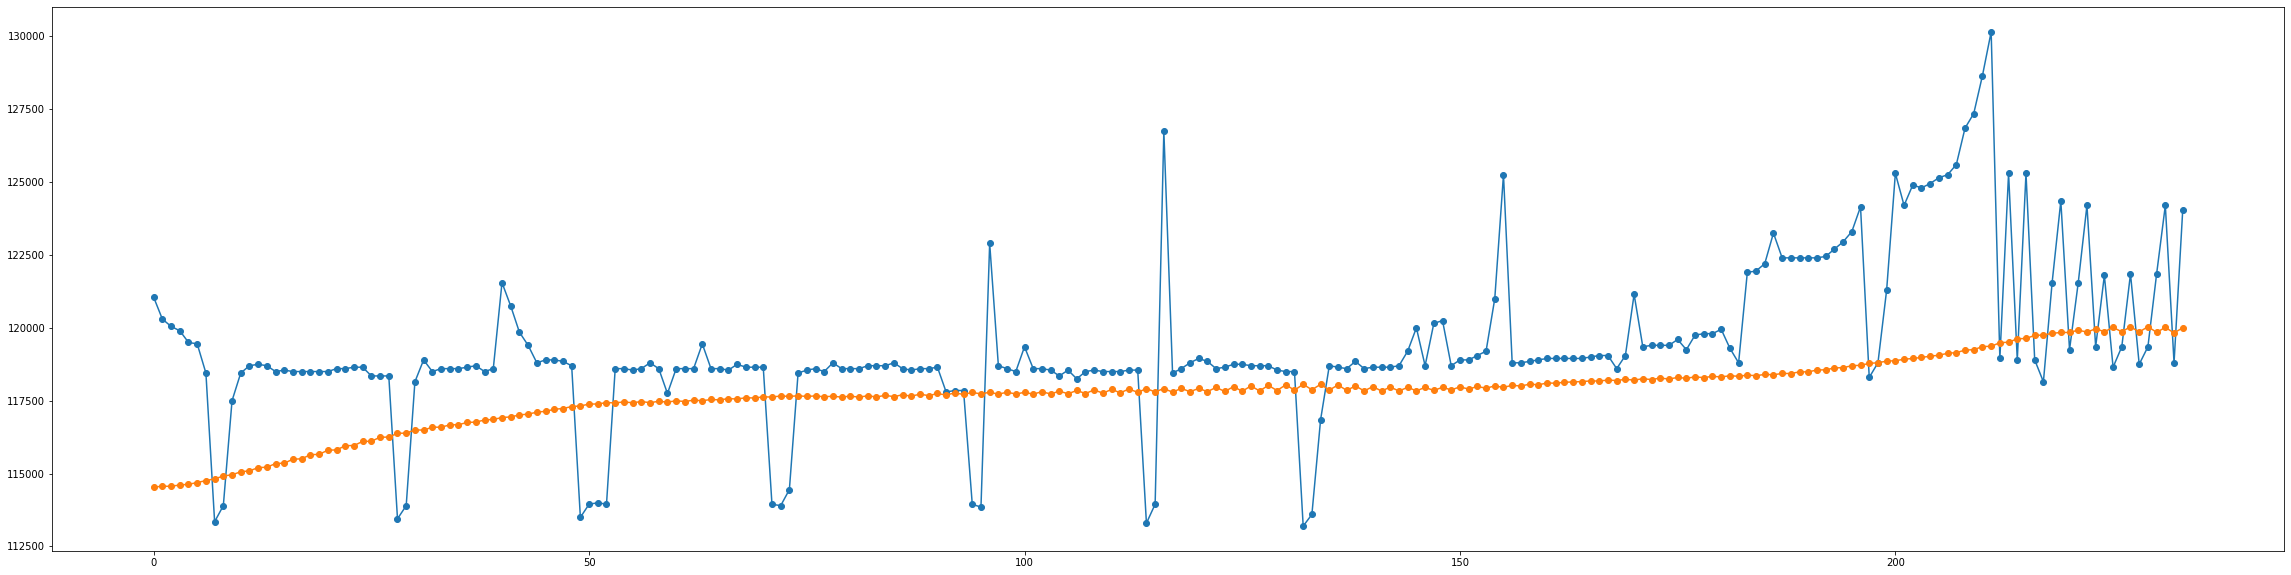

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_sapi21['actual'], '-o')
plt.plot(range(len(x_test)), data_new_sapi21['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0050 - mae: 0.0428 - mape: 567166.2500 - val_loss: 0.0574 - val_mae: 0.1838 - val_mape: 69.1357
Epoch 2/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0050 - mae: 0.0432 - mape: 667301.1875 - val_loss: 0.0577 - val_mae: 0.1839 - val_mape: 68.8857
Epoch 3/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0049 - mae: 0.0413 - mape: 652206.1250 - val_loss: 0.0579 - val_mae: 0.1845 - val_mape: 68.9491
Epoch 4/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0049 - mae: 0.0415 - mape: 646341.6250 - val_loss: 0.0574 - val_mae: 0.1854 - val_mape: 70.4105
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0047 - mae: 0.0401 - mape: 653733.6875 - val_loss: 0.0573 - val_mae: 0.1858 - val_mape: 70.9117
Epoch 6/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0048 - mae: 0.0410 - mape: 658121.9375 - val_loss: 0.0584 - val_

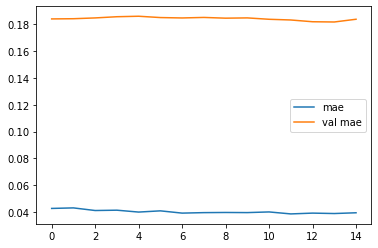

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1691.6409 1.4065031 2913.4096862611


,actual,prediction
0,121050,114346.148438
1,120300,114353.085938
2,120050,114427.640625
3,119900,114530.289062
4,119500,114684.023438
...,...,...
229,119350,121553.585938
230,121850,121586.296875
231,124200,121517.617188
232,118800,121532.914062


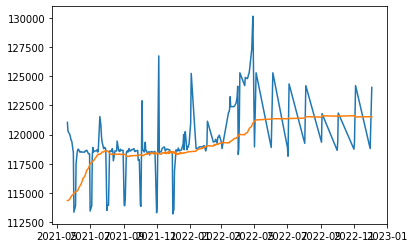

In [ ]:
prediction1_1 = forecast_predict(model1, test_sapi2_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_sapi21_1 = pd.DataFrame()
data_new_sapi21_1['actual'] = x_test
data_new_sapi21_1['prediction'] = data_result1_1
data_new_sapi21_1.to_csv('sapi2_model2_adam_type2.csv')

plt.plot(y_test, data_new_sapi21_1.actual)
plt.plot(y_test, data_new_sapi21_1.prediction)
data_new_sapi21_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 17s 55ms/step - loss: 0.0405 - mae: 0.1347 - mape: 1124705.5000 - val_loss: 0.0614 - val_mae: 0.1900 - val_mape: 64.6293
Epoch 2/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0036 - mae: 0.0320 - mape: 1094699.6250 - val_loss: 0.0589 - val_mae: 0.1838 - val_mape: 65.9563
Epoch 3/15
84/84 [==============================] - 2s 21ms/step - loss: 0.0038 - mae: 0.0332 - mape: 1109237.3750 - val_loss: 0.0637 - val_mae: 0.1960 - val_mape: 63.9030
Epoch 4/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0037 - mae: 0.0324 - mape: 1128183.8750 - val_loss: 0.0589 - val_mae: 0.1839 - val_mape: 65.8935
Epoch 5/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0037 - mae: 0.0338 - mape: 1137083.1250 - val_loss: 0.0636 - val_mae: 0.1958 - val_mape: 63.9417
Epoch 6/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0037 - mae: 0.0331 - mape: 1074049.1250 - val_loss: 0.0630 - val

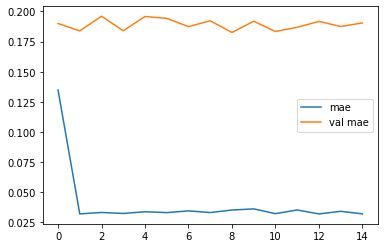

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 5ms/step
2279.1545 1.8898504 2986.532270041628


,actual,prediction
0,121050,114270.859375
1,120300,114290.929688
2,120050,114287.992188
3,119900,114312.414062
4,119500,114334.039062
...,...,...
229,119350,119732.726562
230,121850,119656.039062
231,124200,119700.085938
232,118800,119622.171875


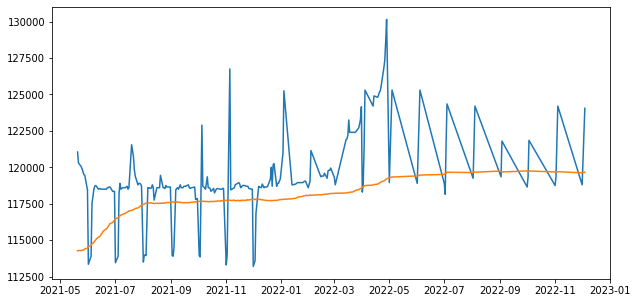

In [ ]:
prediction1_2 = forecast_predict(model1, test_sapi2_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_sapi21_2 = pd.DataFrame()
data_new_sapi21_2['actual'] = x_test
data_new_sapi21_2['prediction'] = data_result1_2
data_new_sapi21_2.to_csv('sapi2_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi21_2.actual)
plt.plot(y_test, data_new_sapi21_2.prediction)

data_new_sapi21_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 41ms/step - loss: 0.2307 - mae: 0.4784 - mape: 99.7646 - val_loss: 0.1807 - val_mae: 0.3521 - val_mape: 76.3446
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.1464 - mae: 0.3808 - mape: 79.3381 - val_loss: 0.1400 - val_mae: 0.2931 - val_mape: 57.9289
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 0.1001 - mae: 0.3145 - mape: 65.4644 - val_loss: 0.1122 - val_mae: 0.2617 - val_mape: 56.0160
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0696 - mae: 0.2617 - mape: 54.4204 - val_loss: 0.0926 - val_mae: 0.2406 - val_mape: 58.5519
Epoch 5/15
44/44 [==============================] - 1s 24ms/step - loss: 0.0482 - mae: 0.2173 - mape: 45.1299 - val_loss: 0.0792 - val_mae: 0.2226 - val_mape: 60.7061
Epoch 6/15
44/44 [==============================] - 1s 30ms/step - loss: 0.0333 - mae: 0.1797 - mape: 37.2699 - val_loss: 0.0702 - val_mae: 0.2072 - val_mape: 62.549

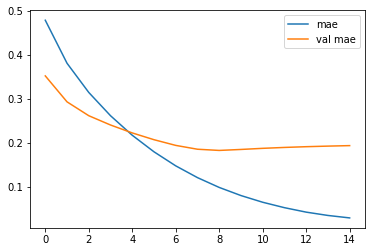

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
2757.987 2.2820196 3505.4916916175966


,actual,prediction
0,121050,116488.046875
1,120300,116490.093750
2,120050,116504.328125
3,119900,116510.492188
4,119500,116533.484375
...,...,...
229,119350,117150.218750
230,121850,117131.335938
231,124200,117151.804688
232,118800,117134.789062


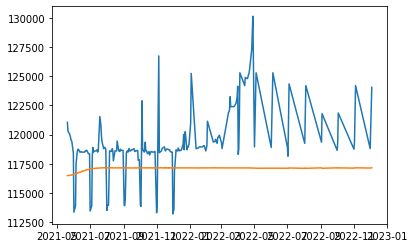

In [ ]:
prediction1_a = forecast_predict(model1_a, test_sapi2_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_sapi21_a = pd.DataFrame()
data_new_sapi21_a['actual'] = x_test
data_new_sapi21_a['prediction'] = data_result1_a
data_new_sapi21_a.to_csv('sapi2_model2_sgd_type1.csv')


plt.plot(y_test, data_new_sapi21_a.actual)
plt.plot(y_test, data_new_sapi21_a.prediction)

data_new_sapi21_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0079 - mae: 0.0680 - mape: 611145.1250 - val_loss: 0.0565 - val_mae: 0.1937 - val_mape: 83.4136
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0077 - mae: 0.0663 - mape: 541775.5000 - val_loss: 0.0565 - val_mae: 0.1940 - val_mape: 83.7520
Epoch 3/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0077 - mae: 0.0659 - mape: 550481.5625 - val_loss: 0.0564 - val_mae: 0.1934 - val_mape: 83.0645
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0075 - mae: 0.0640 - mape: 529710.1875 - val_loss: 0.0564 - val_mae: 0.1929 - val_mape: 82.5027
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0074 - mae: 0.0642 - mape: 569448.7500 - val_loss: 0.0564 - val_mae: 0.1931 - val_mape: 82.7297
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0072 - mae: 0.0621 - mape: 530038.3125 - val_loss: 0.0564 - val

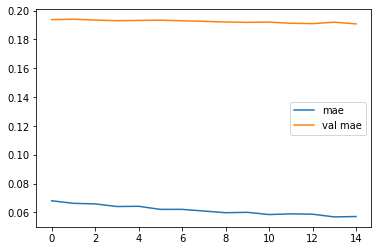

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2460.5278 2.035457 3262.560957284936


,actual,prediction
0,121050,116014.023438
1,120300,116019.289062
2,120050,116040.140625
3,119900,116054.539062
4,119500,116093.546875
...,...,...
229,119350,117733.726562
230,121850,117699.070312
231,124200,117724.601562
232,118800,117694.046875


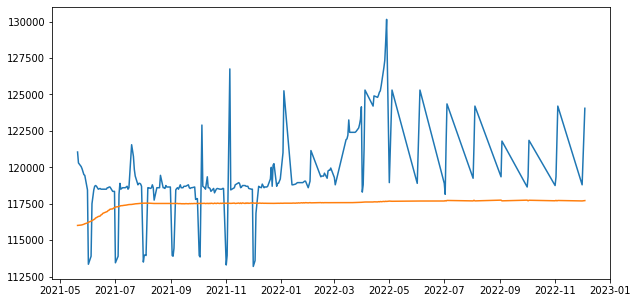

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_sapi2_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_sapi21_a1 = pd.DataFrame()
data_new_sapi21_a1['actual'] = x_test
data_new_sapi21_a1['prediction'] = data_result1_a1
data_new_sapi21_a1.to_csv('sapi2_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi21_a1.actual)
plt.plot(y_test, data_new_sapi21_a1.prediction)
data_new_sapi21_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0037 - mae: 0.0316 - mape: 1119246.3750 - val_loss: 0.0560 - val_mae: 0.1905 - val_mape: 79.6185
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0037 - mae: 0.0318 - mape: 1117770.7500 - val_loss: 0.0560 - val_mae: 0.1904 - val_mape: 79.4635
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0037 - mae: 0.0317 - mape: 1118627.8750 - val_loss: 0.0560 - val_mae: 0.1905 - val_mape: 79.5135
Epoch 4/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0037 - mae: 0.0319 - mape: 1115312.8750 - val_loss: 0.0560 - val_mae: 0.1905 - val_mape: 79.5222
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0037 - mae: 0.0317 - mape: 1117956.0000 - val_loss: 0.0560 - val_mae: 0.1903 - val_mape: 79.2788
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0037 - mae: 0.0319 - mape: 1114834.0000 - val_loss: 0.0560 - val_

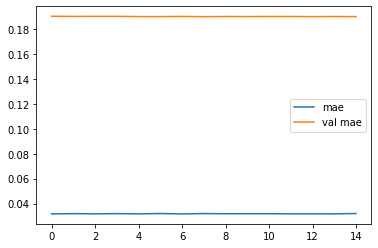

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2466.4978 2.0405018 3264.404539881661


,actual,prediction
0,121050,115959.679688
1,120300,115964.937500
2,120050,115985.804688
3,119900,116000.242188
4,119500,116039.312500
...,...,...
229,119350,117744.578125
230,121850,117707.781250
231,124200,117735.218750
232,118800,117701.945312


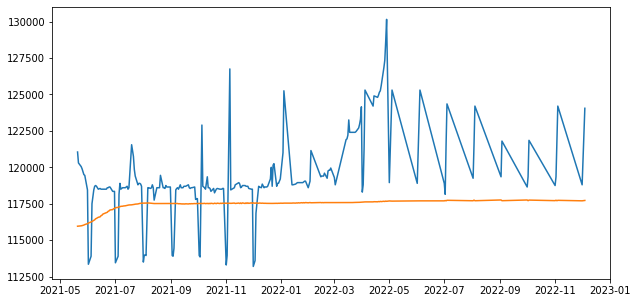

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_sapi2_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_sapi21_a2 = pd.DataFrame()
data_new_sapi21_a2['actual'] = x_test
data_new_sapi21_a2['prediction'] = data_result1_a2
data_new_sapi21_a2.to_csv('sapi2_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi21_a2.actual)
plt.plot(y_test, data_new_sapi21_a2.prediction)

data_new_sapi21_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.2037 - mae: 0.4499 - mape: 93.8286 - val_loss: 0.1794 - val_mae: 0.3504 - val_mape: 75.7141
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.1448 - mae: 0.3789 - mape: 78.9405 - val_loss: 0.1374 - val_mae: 0.2890 - val_mape: 56.8657
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.1015 - mae: 0.3167 - mape: 65.9403 - val_loss: 0.1082 - val_mae: 0.2574 - val_mape: 56.3992
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0706 - mae: 0.2636 - mape: 54.8208 - val_loss: 0.0885 - val_mae: 0.2350 - val_mape: 59.0747
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0488 - mae: 0.2186 - mape: 45.4155 - val_loss: 0.0756 - val_mae: 0.2162 - val_mape: 61.3261
Epoch 6/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0335 - mae: 0.1804 - mape: 37.4092 - val_loss: 0.0673 - val_mae: 0.2004 - val_mape: 63.226

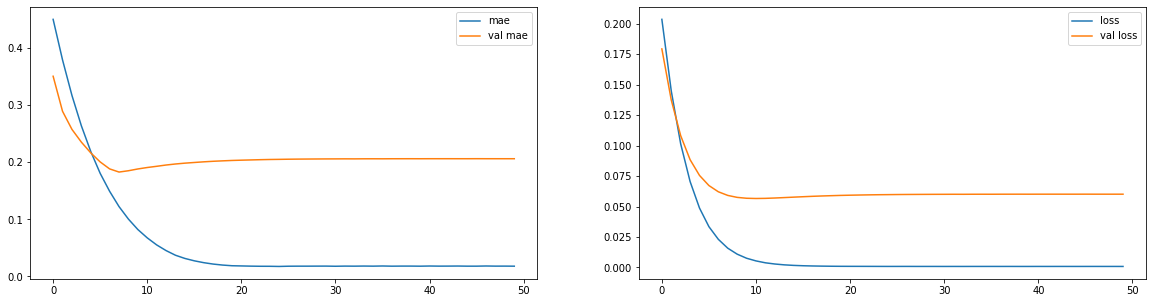

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
2207.5083 1.8247032 3114.2808158546013


,actual,prediction
0,121050,117572.101562
1,120300,117570.289062
2,120050,117568.617188
3,119900,117568.015625
4,119500,117571.273438
...,...,...
229,119350,117830.640625
230,121850,117836.046875
231,124200,117828.945312
232,118800,117834.171875


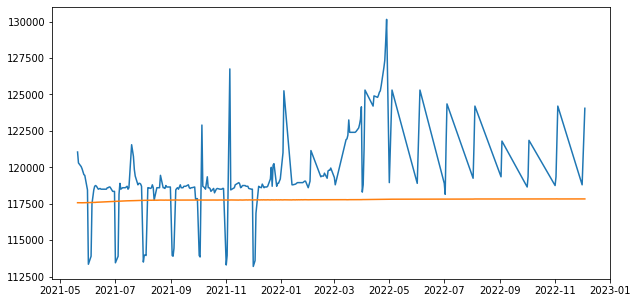

In [ ]:
prediction2 = forecast_predict(model2, test_sapi2_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_sapi22 = pd.DataFrame()
data_new_sapi22['actual'] = x_test
data_new_sapi22['prediction'] = data_result2
data_new_sapi22.to_csv('sapi2_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi22.actual)
plt.plot(y_test, data_new_sapi22.prediction)
data_new_sapi22

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0101 - mae: 0.0789 - mape: 537048.3125 - val_loss: 0.0577 - val_mae: 0.1981 - val_mape: 87.5666
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0091 - mae: 0.0747 - mape: 513525.4062 - val_loss: 0.0576 - val_mae: 0.1977 - val_mape: 87.2056
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0090 - mae: 0.0743 - mape: 516504.6875 - val_loss: 0.0577 - val_mae: 0.1980 - val_mape: 87.4914
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0090 - mae: 0.0747 - mape: 525828.2500 - val_loss: 0.0577 - val_mae: 0.1981 - val_mape: 87.6355
Epoch 5/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0090 - mae: 0.0741 - mape: 557626.4375 - val_loss: 0.0576 - val_mae: 0.1978 - val_mape: 87.3358
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0090 - mae: 0.0736 - mape: 516941.9062 - val_loss: 0.0577 - val_

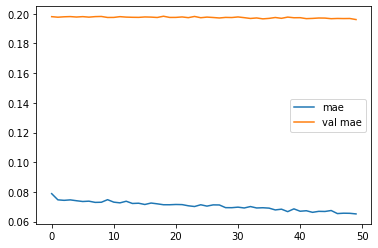

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_sapi2_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_sapi22_1 = pd.DataFrame()
data_new_sapi22_1['actual'] = x_test
data_new_sapi22_1['prediction'] = data_result2_1
data_new_sapi22_1.to_csv('sapi2_model3_sgd_type2.csv')

data_new_sapi22

199/199 [==============================] - 1s 3ms/step
2694.2131 2.2298837 3410.4678564677897


,actual,prediction
0,121050,117572.101562
1,120300,117570.289062
2,120050,117568.617188
3,119900,117568.015625
4,119500,117571.273438
...,...,...
229,119350,117830.640625
230,121850,117836.046875
231,124200,117828.945312
232,118800,117834.171875


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0038 - mae: 0.0342 - mape: 1106639.7500 - val_loss: 0.0571 - val_mae: 0.1964 - val_mape: 85.9332
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0038 - mae: 0.0337 - mape: 1093574.0000 - val_loss: 0.0571 - val_mae: 0.1964 - val_mape: 85.9632
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0039 - mae: 0.0337 - mape: 1118790.8750 - val_loss: 0.0572 - val_mae: 0.1966 - val_mape: 86.1930
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0039 - mae: 0.0338 - mape: 1098502.8750 - val_loss: 0.0572 - val_mae: 0.1965 - val_mape: 86.1280
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0038 - mae: 0.0337 - mape: 1111271.8750 - val_loss: 0.0571 - val_mae: 0.1965 - val_mape: 86.0647
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0039 - mae: 0.0338 - mape: 1098870.0000 - val_loss: 0.0572 - val_

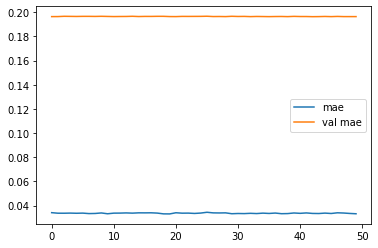

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_sapi2_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_sapi22_2 = pd.DataFrame()
data_new_sapi22_2['actual'] = x_test
data_new_sapi22_2['prediction'] = data_result2_2
data_new_sapi22_2.to_csv('sapi2_model3_sgd-type3.csv')

data_new_sapi22_2

181/181 [==============================] - 1s 4ms/step
2480.2896 2.0521424 3250.9200236240818


,actual,prediction
0,121050,116611.273438
1,120300,116616.757812
2,120050,116611.093750
3,119900,116612.445312
4,119500,116616.546875
...,...,...
229,119350,117789.578125
230,121850,117794.656250
231,124200,117800.804688
232,118800,117812.023438


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 33ms/step - loss: 0.1395 - mae: 0.3634 - mape: 75.6865 - val_loss: 0.0987 - val_mae: 0.2467 - val_mape: 56.5872
Epoch 2/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0059 - mae: 0.0570 - mape: 11.8989 - val_loss: 0.0657 - val_mae: 0.1973 - val_mape: 61.8568
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0014 - mae: 0.0257 - mape: 5.2516 - val_loss: 0.0645 - val_mae: 0.1945 - val_mape: 62.1542
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0016 - mae: 0.0281 - mape: 5.7647 - val_loss: 0.0645 - val_mae: 0.1945 - val_mape: 62.1650
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0014 - mae: 0.0261 - mape: 5.3564 - val_loss: 0.0636 - val_mae: 0.1923 - val_mape: 62.3954
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0014 - mae: 0.0265 - mape: 5.4533 - val_loss: 0.0635 - val_mae: 0.1920 - val_mape: 62.4313
Ep

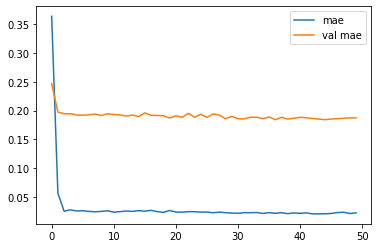

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_sapi2_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_sapi22_a = pd.DataFrame()
data_new_sapi22_a['actual'] = x_test
data_new_sapi22_a['prediction'] = data_result2_a
data_new_sapi22_a.to_csv('sapi2_model3_adam-type1.csv')

data_new_sapi22_a

131/131 [==============================] - 1s 6ms/step
2632.722 2.1813507 3287.542699342474


,actual,prediction
0,121050,115170.046875
1,120300,115176.953125
2,120050,115172.476562
3,119900,115192.828125
4,119500,115199.500000
...,...,...
229,119350,118643.718750
230,121850,118676.039062
231,124200,118765.921875
232,118800,118732.960938


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0053 - mae: 0.0451 - mape: 621617.0000 - val_loss: 0.0568 - val_mae: 0.1835 - val_mape: 69.9569
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0048 - mae: 0.0432 - mape: 627332.8750 - val_loss: 0.0566 - val_mae: 0.1837 - val_mape: 70.4261
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0050 - mae: 0.0425 - mape: 665127.3125 - val_loss: 0.0558 - val_mae: 0.1853 - val_mape: 72.7870
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0049 - mae: 0.0432 - mape: 617189.3750 - val_loss: 0.0566 - val_mae: 0.1834 - val_mape: 70.0857
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0048 - mae: 0.0417 - mape: 632870.6250 - val_loss: 0.0562 - val_mae: 0.1841 - val_mape: 71.2752
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0050 - mae: 0.0429 - mape: 676303.9375 - val_loss: 0.0577 - val_

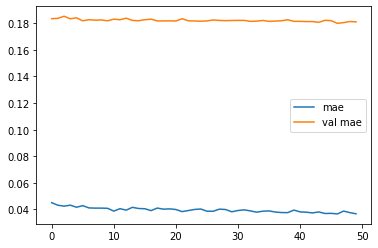

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
2076.7307 1.7230546 2853.3360299831493


,actual,prediction
0,121050,113697.906250
1,120300,113755.734375
2,120050,114011.687500
3,119900,114159.859375
4,119500,114230.062500
...,...,...
229,119350,120399.117188
230,121850,120535.976562
231,124200,120606.296875
232,118800,120602.695312


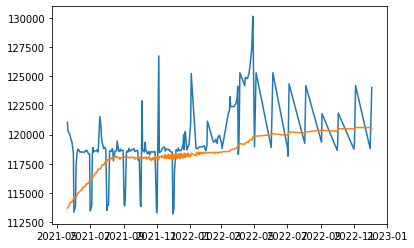

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_sapi2_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_sapi22_a1 = pd.DataFrame()
data_new_sapi22_a1['actual'] = x_test
data_new_sapi22_a1['prediction'] = data_result2_a1
data_new_sapi22_a1.to_csv('sapi2_model3_adam-type2.csv')

plt.plot(y_test, data_new_sapi22_a1.actual)
plt.plot(y_test, data_new_sapi22_a1.prediction)
data_new_sapi22_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0036 - mae: 0.0313 - mape: 1094760.2500 - val_loss: 0.0561 - val_mae: 0.1809 - val_mape: 67.7188
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0036 - mae: 0.0313 - mape: 1085109.0000 - val_loss: 0.0565 - val_mae: 0.1808 - val_mape: 67.2497
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0036 - mae: 0.0310 - mape: 1052679.0000 - val_loss: 0.0562 - val_mae: 0.1810 - val_mape: 67.8346
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0036 - mae: 0.0309 - mape: 1097848.7500 - val_loss: 0.0562 - val_mae: 0.1810 - val_mape: 67.8884
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0036 - mae: 0.0314 - mape: 1090440.0000 - val_loss: 0.0572 - val_mae: 0.1809 - val_mape: 66.7083
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0036 - mae: 0.0331 - mape: 1078062.2500 - val_loss: 0.0562 - val_

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
2429.8435 2.0134842 3172.699796703117


,actual,prediction
0,121050,114122.750000
1,120300,114163.882812
2,120050,114355.812500
3,119900,114474.468750
4,119500,114619.570312
...,...,...
229,119350,119309.187500
230,121850,119405.445312
231,124200,119328.734375
232,118800,119526.328125


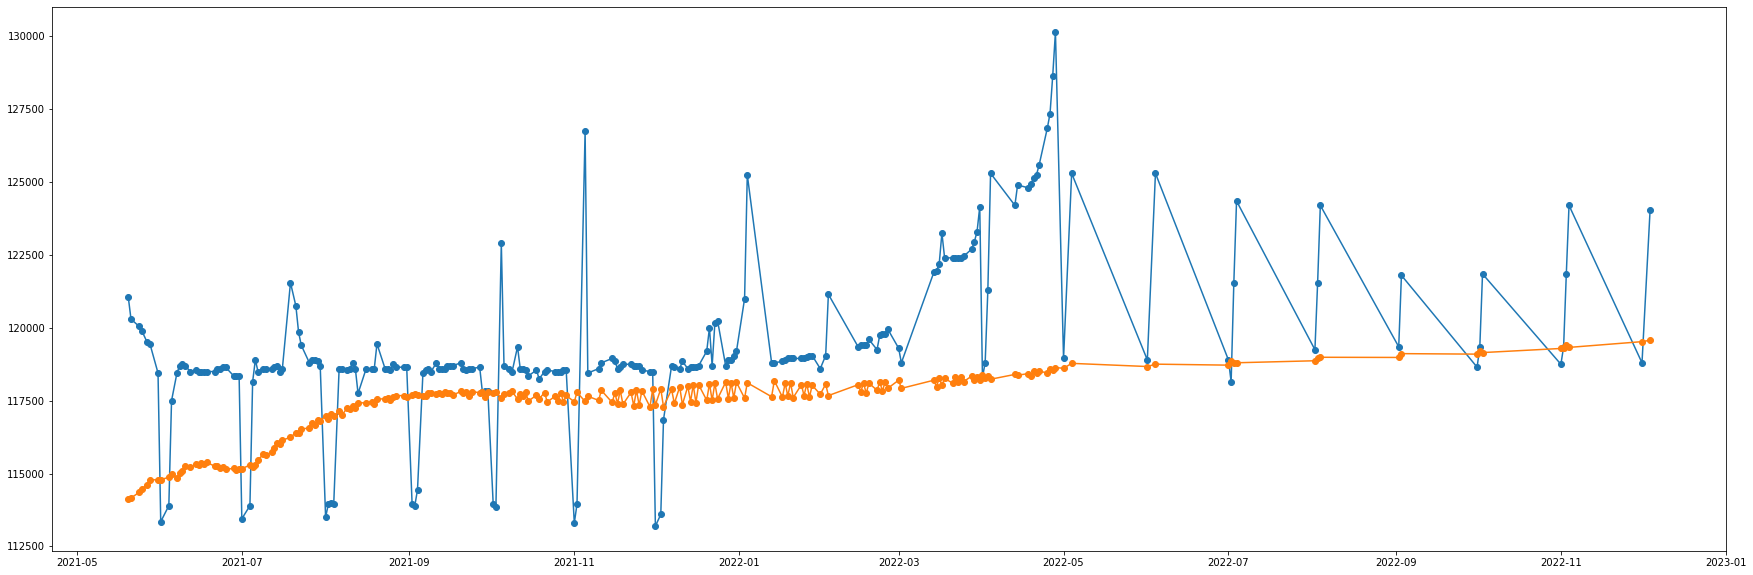

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_sapi2_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_sapi22_a2 = pd.DataFrame()
data_new_sapi22_a2['actual'] = x_test
data_new_sapi22_a2['prediction'] = data_result2_a2
data_new_sapi22_a2.to_csv('sapi2_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_sapi22_a2.actual, '-o')
plt.plot(y_test,data_new_sapi22_a2.prediction, '-o')
data_new_sapi22_a2